<img src="https://stijl.kuleuven.be/releases/latest/img/svg/logo.svg" alt="KU Leuven">

# **Exploring *CroALa* and Marko Marulić**

An exam project for Scripting Languages.

<div class="alert alert-block alert-danger">

<b> THIS NOTEBOOK IS A WORK IN PROGRESS </b>

</div>

This is a Juypter notebook for the exam project for the [Scripting Languages \[G0W95B\]](https://onderwijsaanbod.kuleuven.be/2025/syllabi/e/G0W95BE.html) course of the [Digital Humanities](https://www.kuleuven.be/programmes/master-digital-humanities) programme at [KU Leuven](https://www.kuleuven.be/english/kuleuven/). 

Author:
<br> Petar Soldo
<br> r1076709
<br> [petar.soldo@student.kuleuven.be](mailto:petar.soldo@student.kuleuven.be)

## About the project

The main goal of the project is to perform an "exploratory analysis of data" and "to (...) independently apply the programming techniques explored during the course".

For this purpose, *CroALa* was chosen as a dataset to be analyzed. 

The project has two main goals.

1. Perform a short analysis of the documents in _CroALa_ based on their metadata.
2. Perform a short text analysis of selected works by Marko Marulić.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Marko_Marulic_bust_-_lighting_fix.jpg/250px-Marko_Marulic_bust_-_lighting_fix.jpg" alt="Marko Marulić">

*Bust of Marko Marulić of Split, Croatian poet, by Ivan Meštrović*

*DIREKTOR (talk · contribs), CC0, via Wikimedia Commons*

## *CroALa*

### About *CroALa*

TBA

### What do I want to do?

I want to build a table with the metadata from the XML files in the repository.

To do this I will make a small piece of code that (i) opens every file and extracts the data we need to a list, (ii) appends the list to a dictionary, (iii) turns the dictionary to a *Pandas* dataframe and (iv) exports the dataframe to CSV file. 

The data I want in my table is:
- name of the file
- title of the work
- name of the first author
- date related to the first author
- all mentioned authors and appurtenant dates
- editors of the edition
- languages attributed to the document
- date(s) of creation
- place(s) of creation
- typus
- genres
- (literary) period

### Retrieving metadata about the documents

**NOTE**: This part of the project was largely based on the blog post [*Parsing TEI XML documents with Python*](https://komax.github.io/blog/text/python/xml/parsing_tei_xml_python/) by Maximilian Konzack (2019).

First, let's import all the libraries we need.

In [47]:
from bs4 import BeautifulSoup 
#Make sure you have SoupSieve installed (usually it installs together with BeautifulSoup, when using pip to install)
import lxml
from glob import glob
from os.path import basename
from pprint import pprint
import pandas as pd
import re
import seaborn as sns

We define two functions:
1. *read_tei* for reading the files and
2. *e2t*, short for *element to text*, for extracting the text from an XML element.

Both of these functions were slightly adapted from the aforementioned project: https://komax.github.io/blog/text/python/xml/parsing_tei_xml_python/.

In [2]:
# Take an XML file and return it as a BeutifulSoup object
def read_tei(tei_file):
    with open(tei_file, 'r', encoding = 'utf-8') as tei:
        soup = BeautifulSoup(tei, 'xml')
        return soup
# We can use this new object to navigate the XML document

In [3]:
# Take an XML element and return just its contents
def e2t(elem, default=''):
    if elem:
        return re.sub(r'\s+', ' ', elem.getText(strip=True)) 
        # The regular expression is used to avoid often occuring multiple whitespaces
        # and unsual line breaks, not removed by (strip=True)
    else:
        return default

### Extracting the elements

We can shortly demonstrate how this works. We will choose the first document from the *"texts"* directory.

Let's extract some simple metadata from it.

In [4]:
#This loads the document:
document = read_tei("txts/aa-vv-carm-occ-vd.xml")

#This finds the title:
print(e2t(document.find("title")))

#This finds the (first) author:
print(e2t(document.find("author")))

#This finds the creation date:
print(e2t(document.select_one("profileDesc creation date")))

Carmina occasionalia e codice Traguriensi Variorum Dalmaticorum, versio electronica
Auctores varii
1565-1650


Sometimes, there is more than one piece of information we want to extract from an XML element. It seems that *BeutifulSoup* always returns a list in this case. It is important to not that the `getText()` method does not work on a list, so, if we wish to extract the text from multiple elements, we must iterate throught them.

In [5]:
for author in document.select("titleStmt author"):
    print (e2t(author))

Auctores varii
Grauisius, Iacobus
Mladinić, Sebastijan1561/1563 - 1620-21
Mazarelli, Valerio
Statilić, Marinc. 1650
Pridojević, Ivanc. 1600
Vranius
Gaudentius
Matthaeus Desseus Ragusinus
Michael Racetinus


At first I thought of using the `find` and `find_all` methods, but it seems that `select` and `select_one` allow defining a path by simply writing the elements, separated by a whitespace. This would require chaining the methods when using `find/find_all`.

Thus the selection of all the `author` elements above, using `find_all` would look like this: `document.find("titleStmt").find_all("author")`. The `select(_one)` methods also have a nicer way to access an attribute value.

I thus find the CSS selector methods (`select/select_one`) much more elegant and sufficiently useful for this part of the project.

More about this issue:
- https://www.crummy.com/software/BeautifulSoup/bs4/doc/#css-selectors-through-the-css-property
- https://stackoverflow.com/a/38033910

### Checking how elements behave

Before we go on to extracting the metadata, we should first check what do some of our elements look like. I was forced to perform this check *after* I started buidling a table, because I realized I was not extracting information I wanted or thought I was. However, I will, providently, explain what I checked for and how I did it before going on :)

The elements which needed inspecting were `author` and `creation`. They sometimes encode information in different ways, i.e. by using different tags.

We will first inspect the `author` and `creation` tag. We do this by making use of the `name` method to find the names of the child elements of the `author` element. The follwoin code iterates through the directory and stores all a tagnames to a list first, and then turns list into a set to leave us with unique values only.

In [6]:
tagnames_author = []
tagnames_creation = []

# Iterate through documents and save all tag names to the tagnames list.
for filename in glob("txts/*.xml"):
    doc = read_tei(filename)
    #We check if the element we want exists
    if doc.select_one("titleStmt author"):
        for element in doc.select_one("titleStmt author"):
            tagnames_author.append(element.name)
    else:
        tagnames_author.append('')

    if doc.select_one("profileDesc creation"):
        for element in doc.select_one("profileDesc creation"):
            tagnames_creation.append(element.name)
    else:
        tagnames_creation.append('')

In [7]:
# Make a set to leave only unique values
tagset_author = set(tagnames_author)
tagset_creation = set(tagnames_creation)
print(f"Tags appearing in children of the 'author' element are: {tagset_author} and tags appearing in children of the 'creation' element are {tagset_creation}.")

Tags appearing in children of the 'author' element are: {None, '', 'persName', 'orgName', 'placeName', 'date', 'ref'} and tags appearing in children of the 'creation' element are {None, 'placeName', 'address', 'date'}.


We now have a list (a set to be more precise) of all tags which appear as chidren of the `author` and `creation` tag. We go on further to inspect in which files do these tags appear and what do they contain.

In [8]:
# Create lists to store the elements we want to inspect
# Elements of author
ref= []
placeName = []
orgName = []

# Elements of creation
address_c = []
placeName_c = []


for file in glob("txts/*.xml"):
    doc = read_tei(file)
    # Find the elemenets and store the to list, together with the filename
    # Elements of author
    if doc.select_one("titleStmt author ref"):
        ref.append([file, doc.select_one("titleStmt author ref")])
    if doc.select_one("titleStmt author placeName"):
        placeName.append([file, doc.select_one("titleStmt author placeName")])
    if doc.select_one("titleStmt author orgName"):
        orgName.append([file, doc.select_one("titleStmt author orgName")])
    # Elements of creation
    if doc.select_one("profileDesc creation address"):
        address_c.append([file, doc.select_one("profileDesc creation address")])
    if doc.select_one("profileDesc creation placeName"):
        placeName_c.append([file, doc.select_one("profileDesc creation placeName")])

We can now see what type of data these tags marks contain and in which file we can find them. This can further on be used to indeed inspect the files and decide how to extract the data.

In [9]:
pprint(ref[:3])
pprint(placeName[:3])
pprint(orgName[:3])
pprint(address_c[:3])
pprint(placeName_c[:3])

[['txts\\andreis-f-1529-02-15.xml',
  <ref target="http://www.wikidata.org/entity/Q16115490" type="wikidata">Andreis, Franjo Trankvil</ref>],
 ['txts\\cikulin-if-ideae.xml',
  <ref target="http://www.wikidata.org/entity/Q860595">Čikulin, Ivan Franjo</ref>],
 ['txts\\donat-mandel-sissiensis.xml',
  <ref target="donat01">Donati, Ivan</ref>]]
[['txts\\barletius-scodrensi-obsidione-1504.xml',
  <placeName>Skadar</placeName>],
 ['txts\\barletius-vita-castrioti-1508.xml', <placeName>Skadar</placeName>],
 ['txts\\goineo-gb-situistriae-1543.xml', <placeName>Piran</placeName>]]
[['txts\\aa-vv-carm-occ-vd.xml',
  <orgName ref="#varii-1650">Auctores varii</orgName>],
 ['txts\\aa-vv-epigr-mulla.xml',
  <orgName ref="#varii-1552">Auctores varii</orgName>],
 ['txts\\aa-vv-epigr-tres.xml',
  <orgName ref="#varii-1600">Auctores varii</orgName>]]
[['txts\\aa-vv-carmina-vgc.xml',
  <address>
<addrLine>Romae</addrLine>
<addrLine>Ragusae</addrLine>
</address>],
 ['txts\\andreis-f-philos.xml',
  <address>


### Making a table out of the metadata

We can finally make a table out of the metadata. We initialize a list `croala_data` to which we will append a dictionary of values corresponding to the metadata for every XML file in our `txts` directory. This list of dictionaries is  then used to create a Panadas dataframe. In the end, we dump it to a csv file.

In [33]:
croala_data = []

for filename in glob("txts/*.xml"):
    doc = read_tei(filename)
    
    # Extract titles
    titles = e2t(doc.select_one("titleStmt title"))

    # Extract first author name
    if doc.select_one("titleStmt author"):
        if doc.select_one("titleStmt author").find("orgName"):
            first_author = e2t(doc.select_one("titleStmt author orgName"))
        elif doc.select_one("titleStmt author").find("persName"):
            first_author = e2t(doc.select_one("titleStmt author persName"))
    else:
        first_author = ''

    #Extrat first author date
    if doc.select_one("titleStmt author"):
        first_author_date = e2t(doc.select_one("titleStmt author").find("date"))
    else:
        first_author_date = ''
    
    # Extract all authors
    all_authors = [(re.sub(r'\s+', ' ', a.get_text(separator = ", ", strip=True))) for a in doc.select("author")]

    # Extract editors
    editors = [e2t(e) for e in doc.select("titleStmt editor persName ref")]

    # Extract language
    language = [l["ident"] for l in doc.select("profileDesc langUsage language")]

    # Extract place
    if doc.select_one("profileDesc creation"):
        if doc.select("profileDesc creation placeName"):
            place = [e2t(pl) for pl in doc.select("profileDesc creation placeName")]
        elif doc.select_one("profileDesc creation address"):
            place = [e2t(add) for add in doc.select("profileDesc creation addrLine")]
        else:
            place = ''
    else:
        place = ''

    # Extract date
    date = [e2t(d) for d in doc.select("profileDesc creation date")]

    # Extract typus
    typus = e2t(doc.select_one("textClass keywords[scheme=typus] term"))

    # Extract genres
    genres = [e2t(g) for g in doc.select("textClass keywords[scheme=genre] term")]

    # Extract period
    for ae in doc.select("textClass keywords[scheme=aetas]"):
        period = [e2t(term) for term in ae.select("term")]

    # Append as a dictionary
    croala_data.append({
        "filename": basename(filename),
        "titles": titles,
        "first_author": first_author,
        "first_author_date": first_author_date,
        "all_authors": all_authors,
        "editors": editors,
        "language": language,
        "date": date,
        "place": place,
        "typus": typus,
        "genres": genres,
        "period": period
    })

# Convert to a dataframe
croala_df = pd.DataFrame(croala_data)
croala_df.head()

,filename,titles,first_author,first_author_date,all_authors,editors,language,date,place,typus,genres,period
0,aa-vv-carm-occ-vd.xml,Carmina occasionalia e codice Traguriensi Vari...,Auctores varii,,"[Auctores varii, Grauisius, Iacobus, Mladinić,...",[Neven Jovanović],[lat],[1565-1650],,poesis,"[poesis - epigramma, poesis - elegia]","[Litterae renatae (1400-1600), Saeculum 16 (15..."
1,aa-vv-carmina-vgc.xml,Carmina minora ex libro De vita et gestis Chri...,"Bunić, Jakov",1469-1534,"[Bunić, Jakov, 1469-1534, Caluus, Hieronymus, ...",[Neven Jovanović],[lat],[a. 1502--1526],"[Romae, Ragusae]",poesis,"[poesis - carmen, poesis - epigramma, poesis -...","[Litterae renatae (1400-1600), Saeculum 16 (15..."
2,aa-vv-epigr-mulla.xml,Ad clarissimum uirum dominum Benedictum de Mul...,Auctores varii,,"[Auctores varii, Martinčić, Jerolim, Alberti, ...",[Neven Jovanović],[lat],[1549-1552],,poesis,"[poesis - epigramma, poesis - encomium]","[Litterae renatae (1400-1600), Saeculum 16 (15..."
3,aa-vv-epigr-natal.xml,"Epigrammata in codice Natalis, versio electronica","Kabalin, Grgur",,"[Kabalin, Grgur, Tolimerić, Ilija, m. 1537?]",[Miroslav Marcovich],[lat],[post 1536],,poesis,"[poesis - carmen, poesis - elegia, poesis - ep...","[Litterae renatae (1400-1600), Saeculum 16 (15..."
4,aa-vv-epigr-tres.xml,"Tres invicem epigrammata, versio electronica",Auctores varii,,"[Auctores varii, Kabalin, Grgur, Chrysogonus]",[Neven Jovanović],[lat],[c. 1600.],,poesis,[poesis - epigramma],"[Litterae renatae (1400-1600), Saeculum 16 (15..."


### Adding (missing) wordcounts

If we inspect other directories, we can see that the `varia` directory (created in my fork from various files found in the original repository's root) contains a wordcount file, name `croala-wordcounts.xml`. We will add the wordcounts to our dataframe.

This file contains elements, each with the name of the file and the wordcount as attributes. Let's inspect it.

In [35]:
wordcount_doc = read_tei("varia/croala-wordcounts.xml")

print(f"Length of wordcounts: {len(wordcount_doc.select("doc"))}. Length of croala_df filename column: {len(croala_df["filename"])}")

Length of wordcounts: 569. Length of croala_df filename column: 573


We see that there are less elements (and thus documents) in the wordcount file than in our table. Let's see which files are missing. 

We will create a set of filenames appearing in the wordcount file (there they are called "titles") and a set of the `filename` column of our `croala_df`. We can then just subtract the smaller set from the larger and what will remain are the files not covered in the wordcount document.

In [36]:
wc_titles = [wct["title"] for wct in wordcount_doc.select("doc")]
df_filenames = croala_df["filename"].values.tolist()
len(wc_titles)
missing_files = set(df_filenames) - set(wc_titles)
print (missing_files)

{'vrancic-a-epist-1540-03-28.xml', 'vrancic-a-epist-1534-11-06.xml', 'vrancic-a-epist-1540-10-12.xml', 'vrancic-a-epist-1540-07-28.xml'}


If we snoop about the repository, we realize these files do not have a word count because they were added after the word count file was made (this text is being written on 19/12/2025).

We can easily find this information ourselves (and it's a nice small exercise). The simplest way to do this would be to feed the text of the files to a Python library and have it tokenize them. But for consistency's sake, we will use the same method used for the rest of the files. This means using regular expressions to separate tokens.

The regular expression used for token separation can be found in "scripts/xsl/croala-kay-wordcount.xsl", an XSL script calculating the wordcount, and looks like this: `(\W|[0-9])+`. Note that '+ 1' is added to the total count.

You can see the complete file in the original repository [here](https://github.com/nevenjovanovic/croatiae-auctores-latini-textus/blob/master/scripts/xsl/croala-kay-wordcount.xsl).

We use the same regex for our four missing files. We iterate through them, extract just the text, tokenize it and count their length. We then create a dictionary where filenames are keys and word counts are values.

In [37]:
missing_wordcounts = {}
for filename in missing_files:
    miss_doc = read_tei(f"txts/{filename}")
    
    # Create a list of tokens by spliting the text element on the regex and excluding the whitespace(' ')
    tokens = [t for t in re.split(r'(\W|[0-9])+', e2t(miss_doc.find("text"))) if t!=' ']
    wordcount = len(tokens) + 1

    missing_wordcounts[filename]= wordcount

pprint(missing_wordcounts)

{'vrancic-a-epist-1534-11-06.xml': 466,
 'vrancic-a-epist-1540-03-28.xml': 370,
 'vrancic-a-epist-1540-07-28.xml': 286,
 'vrancic-a-epist-1540-10-12.xml': 539}


We now make a dictionary in the same style with the filenames and wordcounts from the `wordcount_doc`. We then update it (using the `.update()` method) to add the four elements from the `missing_wordcounts` dictionary.

In [38]:
wordcount = {}

for doc in wordcount_doc.select("doc"):
    wordcount_filename = doc['title']
    wordcount_wc = doc['wc']
    wordcount[wordcount_filename] = wordcount_wc

#Updating the wordcount with elements from the missing_wordocunts
wordcount.update(missing_wordcounts)

for i in list(wordcount.keys())[:4]:
    print(i, wordcount[i])

aa-vv-carm-occ-vd.xml 1260
aa-vv-carmina-vgc.xml 2865
aa-vv-epigr-mulla.xml 921
aa-vv-epigr-natal.xml 644


We can now add a "word_count" column by using the `map()` method. We use the lambda function to make sure that all values are treated as integers, because it will otherwise give us headaches in later analysis.

In [86]:
croala_df['word_count'] = (croala_df['filename'].map(wordcount)).apply(lambda x: int(x))

In [87]:
croala_df

,filename,titles,first_author,first_author_date,all_authors,editors,language,date,place,typus,genres,period,word_count
0,aa-vv-carm-occ-vd.xml,Carmina occasionalia e codice Traguriensi Vari...,Auctores varii,,"[Auctores varii, Grauisius, Iacobus, Mladinić,...",[Neven Jovanović],[lat],[1565-1650],,poesis,"[poesis - epigramma, poesis - elegia]","[Litterae renatae (1400-1600), Saeculum 16 (15...",1260
1,aa-vv-carmina-vgc.xml,Carmina minora ex libro De vita et gestis Chri...,"Bunić, Jakov",1469-1534,"[Bunić, Jakov, 1469-1534, Caluus, Hieronymus, ...",[Neven Jovanović],[lat],[a. 1502--1526],"[Romae, Ragusae]",poesis,"[poesis - carmen, poesis - epigramma, poesis -...","[Litterae renatae (1400-1600), Saeculum 16 (15...",2865
2,aa-vv-epigr-mulla.xml,Ad clarissimum uirum dominum Benedictum de Mul...,Auctores varii,,"[Auctores varii, Martinčić, Jerolim, Alberti, ...",[Neven Jovanović],[lat],[1549-1552],,poesis,"[poesis - epigramma, poesis - encomium]","[Litterae renatae (1400-1600), Saeculum 16 (15...",921
3,aa-vv-epigr-natal.xml,"Epigrammata in codice Natalis, versio electronica","Kabalin, Grgur",,"[Kabalin, Grgur, Tolimerić, Ilija, m. 1537?]",[Miroslav Marcovich],[lat],[post 1536],,poesis,"[poesis - carmen, poesis - elegia, poesis - ep...","[Litterae renatae (1400-1600), Saeculum 16 (15...",644
4,aa-vv-epigr-tres.xml,"Tres invicem epigrammata, versio electronica",Auctores varii,,"[Auctores varii, Kabalin, Grgur, Chrysogonus]",[Neven Jovanović],[lat],[c. 1600.],,poesis,[poesis - epigramma],"[Litterae renatae (1400-1600), Saeculum 16 (15...",257
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,zamagna-b-odyssea.xml,"Homeri Odyssea Latinis versibus expressa, vers...",Homerus,,"[Homerus, Zamanja, Bernard, 1735-1820]",[Petra Šoštarić],[lat],[1777],,poesis,"[poesis - versio, poesis - epica, poesis - ele...","[Litterae recentiores (1600-1850), Saeculum 18...",95483
569,zamagna-b-osmanidos.xml,"Osmanidos fragmentum, versio electronica","Gundulić, Ivan",1588-1638,"[Gundulić, Ivan, 1588-1638, Zamanja, Bernard, ...",[Neven Jovanović],[lat],[ante 1820],,poesis,"[poesis - versio, poesis - epica, poesis - fra...","[Litterae recentiores (1600-1850), Saeculum 18...",199
570,zavorovic-d-inscriptio.xml,"Inscriptio in aede, versio electronica","Zavorović, Dinko",1540-1608,"[Zavorović, Dinko, 1540-1608]",[Iva Kurelac],[lat],[c. 1600],,prosa,[prosa oratio - inscriptio],"[Litterae recentiores (1600-1850), Saeculum 17...",14
571,zigerius-e-epist.xml,"Epistola cuiusdam pii concionatoris, ex Turcia...","Vlačić Ilirik, Matija",1520-1575,"[Vlačić Ilirik, Matija, 1520-1575, Zigerius, E...",[Stanko Andrić],[lat],[1549-1550],"[Tolna, Magdeburg]",prosa,"[prosa oratio - epistula, poesis - epigramma]","[Litterae renatae (1400-1600), Saeculum 16 (15...",1772


In [41]:
#Export to a csv file
croala_df.to_csv("croala_metadata.csv", index = False, encoding = 'utf-8')

### Exploring the data

We can now explore and visualise the data in our table, using Pandas functions and descriptive statistics.

Let's start with some simple searches first. Here is the total number of authors in the `first_author` column, top ten first authors and a bar chart with top 20 first authors.

There are 217 authors mentioned in the 'first_author' column.

 first_author
Marulić, Marko              33
Vrančić, Antun              33
Anonymus                    25
Andreis, Franjo Trankvil    23
Brodarić, Stjepan           22
Škrlec Lomnički, Nikola     19
Ritter Vitezović, Pavao     14
Vrančić, Mihovil            14
Beneša, Damjan              11
Sobota, Ivan                10
Name: count, dtype: int64

 Axes(0.125,0.11;0.775x0.77)


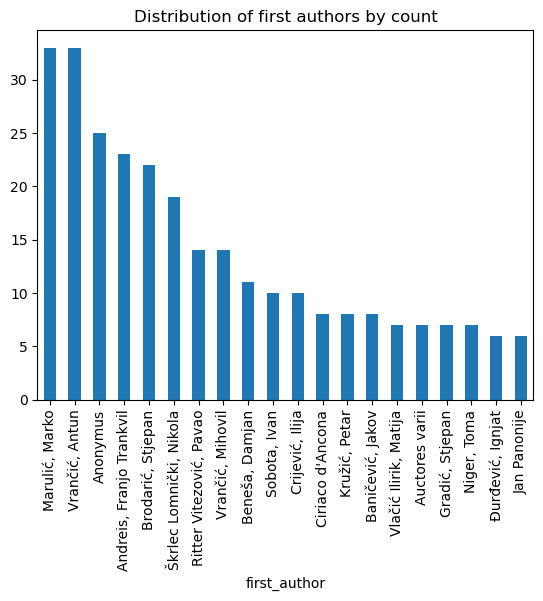

In [72]:
# Counting unique values in the 'first_author' column.
print (f"There are {croala_df["first_author"].nunique()} authors mentioned in the 'first_author' column.")
# Printing ten topmost values by count in the 'first_author' column.
print ("\n", croala_df["first_author"].value_counts().head(10))
# Barchart with 20 topmost first authors.
print("\n", croala_df["first_author"].value_counts().head(20).plot(kind="bar", title="Distribution of first authors by count"))

We can also explore simple statistics for the "typus" value, i.e. what are the ratios of prose vs. poetry.

typus
prosa           344
poesis          228
prosa oratio      1
Name: count, dtype: int64

 Axes(0.22375,0.11;0.5775x0.77)


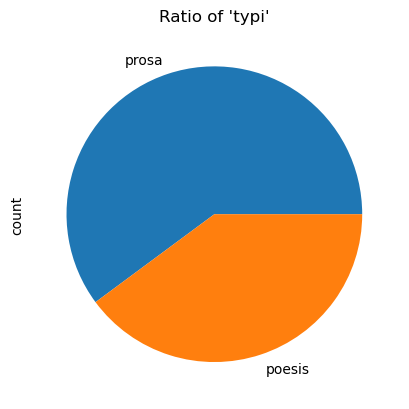

In [76]:
print (croala_df["typus"].value_counts())
print ("\n", croala_df["typus"].value_counts().head(2).plot(kind="pie", title="Ratio of 'typi'"))

Let's do basic descriptive statistics for wordcount.

In [106]:
# Sum of all word counts in the repository.
print (f'There are {(croala_df["word_count"]).sum()} words in total in the repository.')
# Mean word count
print (f'An average document has around {round(croala_df["word_count"].mean())} words.')

# Finding the document with the lowest and highest wordcount

# Locate the document with the min/max wordcount by finding indexes using 'idxmax()'/'idxmin()'
max_wc_doc = croala_df.iloc[(croala_df["word_count"]).idxmax(), 1]
max_wc = (croala_df["word_count"]).max()
min_wc_doc = croala_df.iloc[(croala_df["word_count"]).idxmin(), 1]
min_wc = (croala_df["word_count"]).min()

print(f"Document with the lowest word count is '{min_wc_doc}' with {min_wc} words.", 
      "\n",
      f"Document with the highest word count is '{max_wc_doc}' with {max_wc} words.")

There are 5819338 words in total in the repository.
An average document has around 10156 words.
Document with the lowest word count is 'Janci Alberti inscriptio, versio electronica' with 6 words. 
 Document with the highest word count is 'Clavis scripturae sacrae, pars prima (1580-1581), versio electronica' with 799605 words.
